In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
path = 'Skin_Cancer/hmnist_28_28_RGB.csv'
df = pd.read_csv(path)
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


### Train Test Split


In [6]:
fractions = np.array([0.8, 0.2])
df = df.sample(frac=1)
train_set, test_set = np.array_split(
    df, (fractions[:-1].cumsum() * len(df)).astype(int))

/Users/sundar/miniforge3/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
print(len(train_set))
print(len(test_set))

8012
2003


In [8]:
df.label.unique()

array([4, 2, 5, 0, 6, 1, 3])

In [9]:
classes = {0: ('akiec', 'actinic keratoses and intraepithelial carcinomae'),
           1: ('bcc', 'basal cell carcinoma'),
           2: ('bkl', 'benign keratosis-like lesions'),
           3: ('df', 'dermatofibroma'),
           4: ('nv', ' melanocytic nevi'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           6: ('mel', 'melanoma'), }

In [10]:
y_train = train_set['label']
x_train = train_set.drop(columns=['label'])
y_test = test_set['label']
x_test = test_set.drop(columns=['label'])

columns = list(x_train)

In [12]:
import torch
device = torch.device("mps" if torch.ones(1, device="mps") else "cpu")
print(device)

mps


In [ ]:
import seaborn as sns

sns.countplot(train_set['label'])

In [14]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
x_train, y_train = oversample.fit_resample(x_train, y_train)
x_test, y_test = oversample.fit_resample(x_test, y_test)

In [ ]:
sns.countplot(y_train)

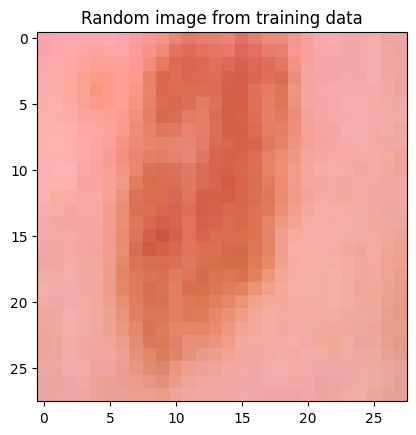

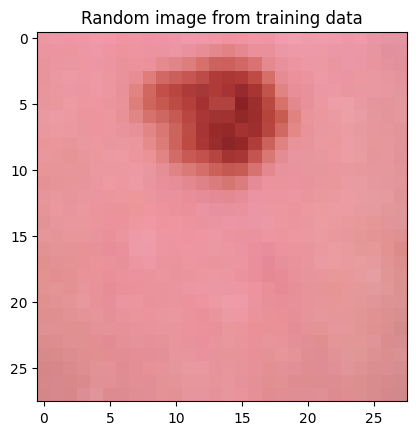

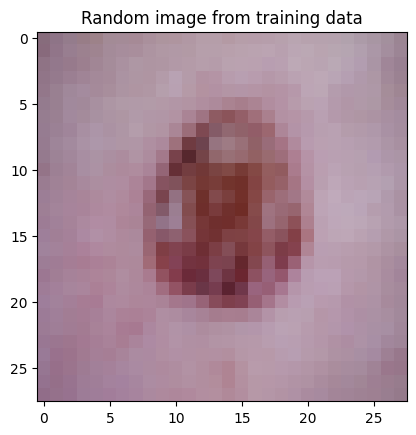

In [58]:
import matplotlib.pyplot as plt
import random
num = random.randint(0, 8000)
x_train = np.array(x_train, dtype=np.uint8).reshape(-1, 28, 28, 3)

plt.imshow(x_train[num].reshape(28, 28, 3))
plt.title("Random image from training data")
plt.show()
num = random.randint(0, 8000)
plt.imshow(x_train[num].reshape(28, 28, 3))
plt.title("Random image from training data")
plt.show()

num = random.randint(0, 8000)
plt.imshow(x_train[num].reshape(28, 28, 3))
plt.title("Random image from training data")
plt.show()

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
import tensorflow as tf

In [60]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(
    28, 28, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.BatchNormalization())

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))

model.add(Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(256, activation='relu'))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(128, activation='relu'))

model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(64, activation='relu'))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(32, activation='relu'))

model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Ba  (None, 14, 14, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 32)        4640      
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 64)         

In [61]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                              monitor='val_acc',
                                              mode='max',
                                              verbose=3,
                                              save_best_only=True
                                              )

In [62]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [63]:
from datetime import datetime
start_time = datetime.now()

history = model.fit(x_train,
                    y_train,
                    validation_split=0.2,
                    batch_size=128,
                    epochs=100,
                    shuffle=True,
                    callbacks=[callback])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/100
236/236 [==============================] - ETA: 0s - loss: 1.3151 - accuracy: 0.5184WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 24s 63ms/step - loss: 1.3151 - accuracy: 0.5184 - val_loss: 2.4643 - val_accuracy: 0.1892
Epoch 2/100
235/236 [============================>.] - ETA: 0s - loss: 0.5205 - accuracy: 0.8377WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.5203 - accuracy: 0.8378 - val_loss: 1.6187 - val_accuracy: 0.3799
Epoch 3/100
235/236 [============================>.] - ETA: 0s - loss: 0.2997 - accuracy: 0.9048WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.2997 - accuracy: 0.9048 - val_loss: 1.4791 - val_accuracy: 0.4044
Epoch 4/100
236/236 [==============================] - ETA: 0s - loss: 0.2102 - accuracy: 0.9306WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.2102 - accuracy: 0.9306 - val_loss: 1.2914 - val_accuracy: 0.4645
Epoch 5/100
234/236 [============================>.] - ETA: 0s - loss: 0.1502 - accuracy: 0.9497WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.1502 - accuracy: 0.9496 - val_loss: 0.6191 - val_accuracy: 0.7293
Epoch 6/100
235/236 [============================>.] - ETA: 0s - loss: 0.1241 - accuracy: 0.9579WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.1241 - accuracy: 0.9579 - val_loss: 1.0552 - val_accuracy: 0.5597
Epoch 7/100
236/236 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 0.9636WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.1051 - accuracy: 0.9636 - val_loss: 0.7300 - val_accuracy: 0.6735
Epoch 8/100
235/236 [============================>.] - ETA: 0s - loss: 0.0907 - accuracy: 0.9680WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0908 - accuracy: 0.9679 - val_loss: 0.9809 - val_accuracy: 0.5874
Epoch 9/100
236/236 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.9697WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0875 - accuracy: 0.9697 - val_loss: 0.3992 - val_accuracy: 0.8193
Epoch 10/100
236/236 [==============================] - ETA: 0s - loss: 0.0596 - accuracy: 0.9796WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0596 - accuracy: 0.9796 - val_loss: 0.6506 - val_accuracy: 0.6765
Epoch 11/100
236/236 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9727WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0783 - accuracy: 0.9727 - val_loss: 0.8726 - val_accuracy: 0.6182
Epoch 12/100
235/236 [============================>.] - ETA: 0s - loss: 0.0486 - accuracy: 0.9826WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0489 - accuracy: 0.9825 - val_loss: 0.2528 - val_accuracy: 0.9063
Epoch 13/100
235/236 [============================>.] - ETA: 0s - loss: 0.0603 - accuracy: 0.9802WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0603 - accuracy: 0.9802 - val_loss: 0.2354 - val_accuracy: 0.9156
Epoch 14/100
235/236 [============================>.] - ETA: 0s - loss: 0.0455 - accuracy: 0.9850WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0456 - accuracy: 0.9849 - val_loss: 0.5206 - val_accuracy: 0.8161
Epoch 15/100
235/236 [============================>.] - ETA: 0s - loss: 0.0703 - accuracy: 0.9766WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0703 - accuracy: 0.9766 - val_loss: 0.3754 - val_accuracy: 0.8583
Epoch 16/100
236/236 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9909WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0297 - accuracy: 0.9909 - val_loss: 0.2090 - val_accuracy: 0.9277
Epoch 17/100
236/236 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9924WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0251 - accuracy: 0.9924 - val_loss: 0.2549 - val_accuracy: 0.9096
Epoch 18/100
235/236 [============================>.] - ETA: 0s - loss: 0.0218 - accuracy: 0.9935WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0218 - accuracy: 0.9935 - val_loss: 0.0899 - val_accuracy: 0.9717
Epoch 19/100
236/236 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9907WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0302 - accuracy: 0.9907 - val_loss: 0.2615 - val_accuracy: 0.9051
Epoch 20/100
236/236 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9901WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0316 - accuracy: 0.9901 - val_loss: 1.0473 - val_accuracy: 0.7241
Epoch 21/100
236/236 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9892WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 7s 29ms/step - loss: 0.0336 - accuracy: 0.9892 - val_loss: 1.5966 - val_accuracy: 0.5358
Epoch 22/100
236/236 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9865WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 7s 29ms/step - loss: 0.0421 - accuracy: 0.9865 - val_loss: 0.5375 - val_accuracy: 0.8457
Epoch 23/100
236/236 [==============================] - ETA: 0s - loss: 0.0264 - accuracy: 0.9923WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 7s 29ms/step - loss: 0.0264 - accuracy: 0.9923 - val_loss: 0.1757 - val_accuracy: 0.9531
Epoch 24/100
235/236 [============================>.] - ETA: 0s - loss: 0.0162 - accuracy: 0.9956WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 7s 29ms/step - loss: 0.0161 - accuracy: 0.9956 - val_loss: 0.4953 - val_accuracy: 0.8315
Epoch 25/100
235/236 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9955WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 7s 29ms/step - loss: 0.0161 - accuracy: 0.9955 - val_loss: 1.0449 - val_accuracy: 0.7049
Epoch 26/100
236/236 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9917WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 7s 29ms/step - loss: 0.0274 - accuracy: 0.9917 - val_loss: 0.7924 - val_accuracy: 0.8235
Epoch 27/100
236/236 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9879WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0386 - accuracy: 0.9879 - val_loss: 1.0849 - val_accuracy: 0.7015
Epoch 28/100
234/236 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.9930WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 7s 28ms/step - loss: 0.0249 - accuracy: 0.9929 - val_loss: 0.3138 - val_accuracy: 0.8983
Epoch 29/100
236/236 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9941WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0191 - accuracy: 0.9941 - val_loss: 0.1335 - val_accuracy: 0.9592
Epoch 30/100
235/236 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.9945WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0192 - accuracy: 0.9945 - val_loss: 0.3041 - val_accuracy: 0.8930
Epoch 31/100
236/236 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9887WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 7s 28ms/step - loss: 0.0352 - accuracy: 0.9887 - val_loss: 0.1184 - val_accuracy: 0.9662
Epoch 32/100
234/236 [============================>.] - ETA: 0s - loss: 0.0169 - accuracy: 0.9951WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0169 - accuracy: 0.9950 - val_loss: 0.1606 - val_accuracy: 0.9528
Epoch 33/100
235/236 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9972WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0115 - accuracy: 0.9972 - val_loss: 0.3565 - val_accuracy: 0.8905
Epoch 34/100
236/236 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9960WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0155 - accuracy: 0.9960 - val_loss: 0.0678 - val_accuracy: 0.9825
Epoch 35/100
235/236 [============================>.] - ETA: 0s - loss: 0.0184 - accuracy: 0.9951WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0184 - accuracy: 0.9951 - val_loss: 0.1694 - val_accuracy: 0.9559
Epoch 36/100
235/236 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9972WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 7s 28ms/step - loss: 0.0108 - accuracy: 0.9972 - val_loss: 0.0500 - val_accuracy: 0.9875
Epoch 37/100
236/236 [==============================] - ETA: 0s - loss: 0.0203 - accuracy: 0.9941WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0203 - accuracy: 0.9941 - val_loss: 0.1901 - val_accuracy: 0.9310
Epoch 38/100
235/236 [============================>.] - ETA: 0s - loss: 0.0273 - accuracy: 0.9917WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0273 - accuracy: 0.9917 - val_loss: 0.0911 - val_accuracy: 0.9757
Epoch 39/100
234/236 [============================>.] - ETA: 0s - loss: 0.0198 - accuracy: 0.9941WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 7s 28ms/step - loss: 0.0198 - accuracy: 0.9941 - val_loss: 1.0375 - val_accuracy: 0.7329
Epoch 40/100
234/236 [============================>.] - ETA: 0s - loss: 0.0178 - accuracy: 0.9944WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0179 - accuracy: 0.9943 - val_loss: 0.0886 - val_accuracy: 0.9729
Epoch 41/100
234/236 [============================>.] - ETA: 0s - loss: 0.0207 - accuracy: 0.9937WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0208 - accuracy: 0.9937 - val_loss: 0.0525 - val_accuracy: 0.9860
Epoch 42/100
234/236 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9965WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0121 - accuracy: 0.9965 - val_loss: 0.0972 - val_accuracy: 0.9676
Epoch 43/100
235/236 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9960WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0135 - accuracy: 0.9960 - val_loss: 0.0634 - val_accuracy: 0.9854
Epoch 44/100
234/236 [============================>.] - ETA: 0s - loss: 0.0075 - accuracy: 0.9982WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0075 - accuracy: 0.9982 - val_loss: 0.0668 - val_accuracy: 0.9817
Epoch 45/100
235/236 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9942WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0183 - accuracy: 0.9942 - val_loss: 0.6450 - val_accuracy: 0.7732
Epoch 46/100
236/236 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9900WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0338 - accuracy: 0.9900 - val_loss: 0.1649 - val_accuracy: 0.9518
Epoch 47/100
234/236 [============================>.] - ETA: 0s - loss: 0.0074 - accuracy: 0.9984WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0074 - accuracy: 0.9984 - val_loss: 0.0482 - val_accuracy: 0.9930
Epoch 48/100
234/236 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9991WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0047 - accuracy: 0.9991 - val_loss: 0.0952 - val_accuracy: 0.9740
Epoch 49/100
235/236 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9992WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0046 - accuracy: 0.9992 - val_loss: 0.5805 - val_accuracy: 0.8316
Epoch 50/100
234/236 [============================>.] - ETA: 0s - loss: 0.0260 - accuracy: 0.9921WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0259 - accuracy: 0.9921 - val_loss: 0.9351 - val_accuracy: 0.7487
Epoch 51/100
234/236 [============================>.] - ETA: 0s - loss: 0.0123 - accuracy: 0.9974WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0123 - accuracy: 0.9974 - val_loss: 0.4966 - val_accuracy: 0.8433
Epoch 52/100
235/236 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.9929WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0231 - accuracy: 0.9929 - val_loss: 0.6260 - val_accuracy: 0.8078
Epoch 53/100
235/236 [============================>.] - ETA: 0s - loss: 0.0239 - accuracy: 0.9937WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0239 - accuracy: 0.9937 - val_loss: 0.1252 - val_accuracy: 0.9650
Epoch 54/100
234/236 [============================>.] - ETA: 0s - loss: 0.0162 - accuracy: 0.9960WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0164 - accuracy: 0.9959 - val_loss: 0.6188 - val_accuracy: 0.8171
Epoch 55/100
234/236 [============================>.] - ETA: 0s - loss: 0.0249 - accuracy: 0.9932WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0248 - accuracy: 0.9932 - val_loss: 0.1083 - val_accuracy: 0.9649
Epoch 56/100
234/236 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.9970WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0139 - accuracy: 0.9970 - val_loss: 0.1691 - val_accuracy: 0.9510
Epoch 57/100
234/236 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9965WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0151 - accuracy: 0.9965 - val_loss: 0.3214 - val_accuracy: 0.9030
Epoch 58/100
234/236 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9962WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0146 - accuracy: 0.9962 - val_loss: 0.0795 - val_accuracy: 0.9834
Epoch 59/100
236/236 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9966WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0139 - accuracy: 0.9966 - val_loss: 0.2680 - val_accuracy: 0.9252
Epoch 60/100
235/236 [============================>.] - ETA: 0s - loss: 0.0218 - accuracy: 0.9947WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0219 - accuracy: 0.9947 - val_loss: 0.0979 - val_accuracy: 0.9758
Epoch 61/100
234/236 [============================>.] - ETA: 0s - loss: 0.0272 - accuracy: 0.9920WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0271 - accuracy: 0.9920 - val_loss: 0.3234 - val_accuracy: 0.8942
Epoch 62/100
236/236 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9946WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0191 - accuracy: 0.9946 - val_loss: 0.1501 - val_accuracy: 0.9557
Epoch 63/100
235/236 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9964WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0144 - accuracy: 0.9963 - val_loss: 0.1455 - val_accuracy: 0.9407
Epoch 64/100
236/236 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9957WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0152 - accuracy: 0.9957 - val_loss: 0.1536 - val_accuracy: 0.9527
Epoch 65/100
235/236 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9972WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0105 - accuracy: 0.9972 - val_loss: 0.0363 - val_accuracy: 0.9900
Epoch 66/100
234/236 [============================>.] - ETA: 0s - loss: 0.0109 - accuracy: 0.9970WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0109 - accuracy: 0.9970 - val_loss: 0.3816 - val_accuracy: 0.8849
Epoch 67/100
235/236 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9931WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0227 - accuracy: 0.9931 - val_loss: 0.2862 - val_accuracy: 0.9002
Epoch 68/100
234/236 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9964WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0128 - accuracy: 0.9964 - val_loss: 0.2926 - val_accuracy: 0.9056
Epoch 69/100
236/236 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9967WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0134 - accuracy: 0.9967 - val_loss: 0.3046 - val_accuracy: 0.9005
Epoch 70/100
235/236 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.9941WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0200 - accuracy: 0.9941 - val_loss: 2.2058 - val_accuracy: 0.5838
Epoch 71/100
234/236 [============================>.] - ETA: 0s - loss: 0.0191 - accuracy: 0.9947WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0191 - accuracy: 0.9947 - val_loss: 0.3304 - val_accuracy: 0.8835
Epoch 72/100
235/236 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9969WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 7s 28ms/step - loss: 0.0124 - accuracy: 0.9969 - val_loss: 0.1945 - val_accuracy: 0.9269
Epoch 73/100
236/236 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9970WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0119 - accuracy: 0.9970 - val_loss: 0.0376 - val_accuracy: 0.9867
Epoch 74/100
235/236 [============================>.] - ETA: 0s - loss: 0.0261 - accuracy: 0.9919WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0261 - accuracy: 0.9919 - val_loss: 0.1059 - val_accuracy: 0.9698
Epoch 75/100
236/236 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9972WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 27ms/step - loss: 0.0106 - accuracy: 0.9972 - val_loss: 0.0214 - val_accuracy: 0.9935
Epoch 76/100
234/236 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9979WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0089 - accuracy: 0.9978 - val_loss: 0.0285 - val_accuracy: 0.9916
Epoch 77/100
234/236 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.9982WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0070 - accuracy: 0.9982 - val_loss: 0.0599 - val_accuracy: 0.9872
Epoch 78/100
236/236 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9977WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0092 - accuracy: 0.9977 - val_loss: 0.1457 - val_accuracy: 0.9479
Epoch 79/100
236/236 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9984WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.2078 - val_accuracy: 0.9188
Epoch 80/100
235/236 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9966WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0138 - accuracy: 0.9966 - val_loss: 0.2074 - val_accuracy: 0.9281
Epoch 81/100
236/236 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9966WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0122 - accuracy: 0.9966 - val_loss: 0.2181 - val_accuracy: 0.9124
Epoch 82/100
236/236 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9982WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0072 - accuracy: 0.9982 - val_loss: 0.0203 - val_accuracy: 0.9918
Epoch 83/100
235/236 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9970WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0107 - accuracy: 0.9970 - val_loss: 0.2074 - val_accuracy: 0.9164
Epoch 84/100
235/236 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9959WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0144 - accuracy: 0.9959 - val_loss: 0.9036 - val_accuracy: 0.7619
Epoch 85/100
234/236 [============================>.] - ETA: 0s - loss: 0.0086 - accuracy: 0.9976WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0085 - accuracy: 0.9976 - val_loss: 0.0112 - val_accuracy: 0.9981
Epoch 86/100
236/236 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9990WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0051 - accuracy: 0.9990 - val_loss: 0.0441 - val_accuracy: 0.9879
Epoch 87/100
235/236 [============================>.] - ETA: 0s - loss: 0.0074 - accuracy: 0.9981WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0074 - accuracy: 0.9981 - val_loss: 0.3268 - val_accuracy: 0.8783
Epoch 88/100
235/236 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9958WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0144 - accuracy: 0.9958 - val_loss: 0.6013 - val_accuracy: 0.8215
Epoch 89/100
235/236 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9970WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0108 - accuracy: 0.9970 - val_loss: 0.1991 - val_accuracy: 0.9286
Epoch 90/100
234/236 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9961WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0138 - accuracy: 0.9961 - val_loss: 0.0321 - val_accuracy: 0.9942
Epoch 91/100
234/236 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9964WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0130 - accuracy: 0.9963 - val_loss: 0.0792 - val_accuracy: 0.9741
Epoch 92/100
234/236 [============================>.] - ETA: 0s - loss: 0.0050 - accuracy: 0.9992WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0050 - accuracy: 0.9992 - val_loss: 0.0640 - val_accuracy: 0.9805
Epoch 93/100
235/236 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.9990WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.1923 - val_accuracy: 0.9381
Epoch 94/100
235/236 [============================>.] - ETA: 0s - loss: 0.0057 - accuracy: 0.9982WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.2034 - val_accuracy: 0.9285
Epoch 95/100
234/236 [============================>.] - ETA: 0s - loss: 0.0052 - accuracy: 0.9989WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0052 - accuracy: 0.9989 - val_loss: 0.3016 - val_accuracy: 0.9015
Epoch 96/100
235/236 [============================>.] - ETA: 0s - loss: 0.0096 - accuracy: 0.9974WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0096 - accuracy: 0.9974 - val_loss: 0.0802 - val_accuracy: 0.9742
Epoch 97/100
235/236 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9959WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0138 - accuracy: 0.9959 - val_loss: 1.7394 - val_accuracy: 0.6343
Epoch 98/100
235/236 [============================>.] - ETA: 0s - loss: 0.0075 - accuracy: 0.9979WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0075 - accuracy: 0.9979 - val_loss: 0.0162 - val_accuracy: 0.9965
Epoch 99/100
234/236 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9995WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0064 - val_accuracy: 0.9985
Epoch 100/100
235/236 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.9992WARNING:tensorflow:Can save best model only with val_acc available, skipping.


236/236 [==============================] - 6s 26ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0268 - val_accuracy: 0.9939
Duration: 0:10:47.575697


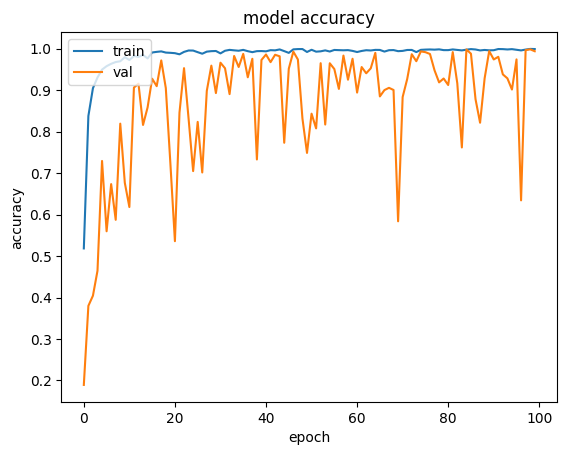

In [65]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

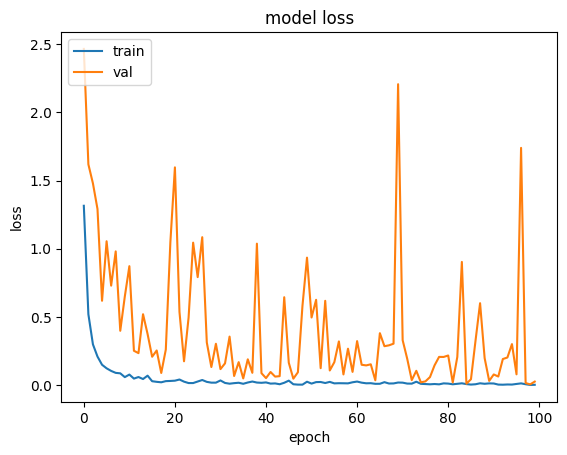

In [64]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [67]:
x_test = np.array(x_test).reshape(-1, 28, 28, 3)
loss, acc = model.evaluate(x_test, y_test, verbose=1)

63/63 [==============================] - 0s 7ms/step - loss: 1.5544 - accuracy: 0.7299


# Save


In [50]:
model.save('./model/Skin_Cancer.h5')

/Users/sundar/miniforge3/envs/myenv/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model = tf.keras.models.load_model('./model/Skin_Cancer.h5')
print(test_set)

y_true = []
y_pred = []

for batch in test_set.values:
    images, labels = batch
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1).tolist()

    y_true.extend(labels.numpy().tolist())
    y_pred.extend(predicted_labels)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate classification report
# Replace with your actual class names
target_names = ["class_0", "class_1", ...]
report = classification_report(y_true, y_pred, target_names=target_names)

print("Classification Report:")
print(report)

# Additionally, you can print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

       pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
4155         233        172        183        231        168        181   
9925         237        141        161        238        151        175   
6167         199         98         98        201         99        102   
5165         193        100        128        178         83        112   
2928         183        141        136        186        142        135   
...          ...        ...        ...        ...        ...        ...   
10007         26         13         19         25         10         17   
3878         210        125        127        209        117        127   
6162         232        145        157        234        145        157   
9162         155        137        136        159        142        144   
9733         148        114        106        155        122        117   

       pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
4155         234   

ValueError: too many values to unpack (expected 2)

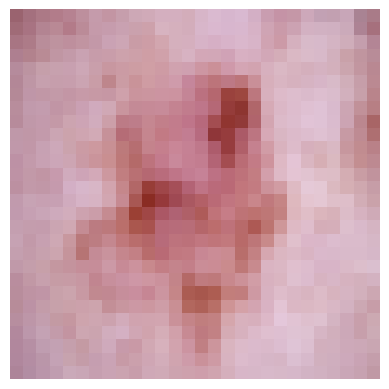

1/1 [==============================] - 1s 1s/step
[9.9673069e-01 6.0877269e-11 1.3526928e-06 2.9094052e-09 2.4159742e-03
 1.1053947e-08 8.5196400e-04]
('akiec', 'actinic keratoses and intraepithelial carcinomae')


In [34]:

import PIL
import matplotlib.pyplot as plt
import numpy as np

image = PIL.Image.open('Skin_Cancer/train/akiec/ISIC_0024372.jpg')
image = image.resize((28, 28))


img = np.array(image)
model = tf.keras.models.load_model('./model/Skin_Cancer.h5')


plt.imshow(img)
plt.axis('off')
plt.show()

img = x_test[1]
img = np.array(image).reshape(-1, 28, 28, 3)
result = model.predict(img)
print(result[0])
result = result.tolist()
max_prob = max(result[0])
class_ind = result[0].index(max_prob)
print(classes[class_ind])